In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initialize a single 2-variate Gaussian.
mvn = tfp.distributions.MultivariateNormalFullCovariance(
    loc=[1., -1],
    covariance_matrix=[[1, 0.],
                       [0., 0.7]])

In [3]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [17]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

In [18]:
tfd = tfp.distributions

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.05), loss=negloglik)

In [19]:
model.fit(x, y, epochs=500, verbose=False)

In [20]:
# Profit.
yhat = model(x_tst)
yhat_mean = K.get_value(yhat.mean())

[print(np.squeeze(K.get_value(w))) for w in model.weights];
assert isinstance(yhat, tfd.Distribution)

0.13186479
5.1219864


In [22]:
yhat_mean.shape

(150, 1)

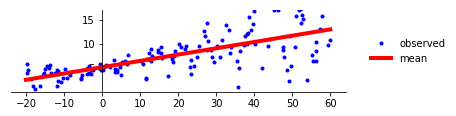

In [11]:
#@title Figure 1: No uncertainty.
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat_mean,'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

#plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

In [12]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1)),#1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(K.get_value(w))) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.14281672 -1.0182048 ]
[5.1377435 0.       ]


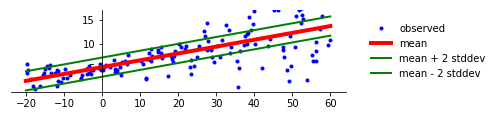

In [13]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = K.get_value(yhat.mean())
s = K.get_value(yhat.stddev())

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [14]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(K.get_value(w))) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.1364388 1.022357 ]
[ 5.2140856 20.775581 ]


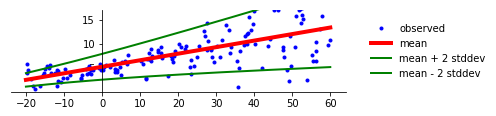

In [15]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = K.get_value(yhat.mean())
s = K.get_value(yhat.stddev())

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [30]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [31]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [32]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(K.get_value(w))) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.1347285  5.1545315 -4.6788177 -2.623482 ]
[0.15406725 5.203264  ]


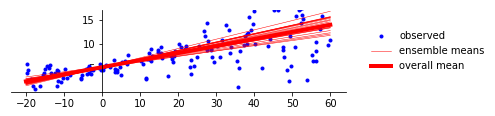

In [31]:
#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [35]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_2 (DenseVa multiple                  12        
_________________________________________________________________
distribution_lambda_4 (Distr multiple                  0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Do inference.
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.12188     2.9946969   5.216027    4.5018263  -3.6408923  -0.91884524
 -2.3070433   0.17789598]
[0.15538414 2.9834676  5.168482   4.7891135 ]


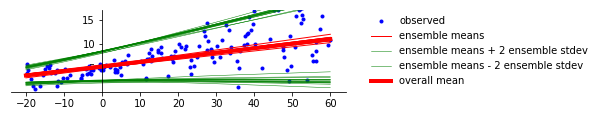

In [38]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))


In [39]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=2000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 1.15858272e-01  5.40172386e+00  5.20784616e+00  1.58995895e+02
 -5.61118221e+00 -1.46483552e+00 -2.08585644e+00  1.19899265e-01]
[  0.18602853   5.387636     5.1905613  159.11699   ]


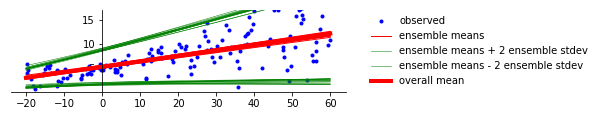

In [40]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))


In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalFullCovariance(loc=t, covariance_matrix=...)),
])

In [24]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  2         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(x, y, epochs=500, verbose=False);

TypeError: in converted code:

    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_probability/python/layers/distribution_layer.py:213 call
        inputs, *args, **kwargs)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py:795 call
        return self.function(inputs, **arguments)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_probability/python/layers/distribution_layer.py:161 _fn
        d = make_distribution_fn(*fargs, **fkwargs)
    <ipython-input-23-945273030739>:3 <lambda>
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalFullCovariance(loc=t, covariance_matrix=...)),
    </sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/decorator.py:decorator-gen-288>:2 __init__
        
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py:276 wrapped_init
        default_init(self_, *args, **kwargs)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_probability/python/distributions/mvn_full_covariance.py:169 __init__
        covariance_matrix, name="covariance_matrix", dtype=dtype)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1242 convert_to_tensor_v2
        as_ref=False)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1296 internal_convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/constant_op.py:286 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/constant_op.py:227 constant
        allow_broadcast=True)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/constant_op.py:265 _constant_impl
        allow_broadcast=allow_broadcast))
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/tensor_util.py:449 make_tensor_proto
        _AssertCompatible(values, dtype)
    /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/framework/tensor_util.py:331 _AssertCompatible
        (dtype.name, repr(mismatch), type(mismatch).__name__))

    TypeError: Expected float32, got Ellipsis of type 'ellipsis' instead.


In [ ]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [45]:
mu = [1., 2, 3]
cov = [[ 0.36,  0.12,  0.06],
       [ 0.12,  0.29, -0.13],
       [ 0.06, -0.13,  0.26]]
mvn = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov)

print(mvn.mean().numpy())
# ==> [1., 2, 3]

[1. 2. 3.]


In [46]:
# Covariance agrees with covariance_matrix.
print(mvn.covariance().numpy())
# ==> [[ 0.36,  0.12,  0.06],
#      [ 0.12,  0.29, -0.13],
#      [ 0.06, -0.13,  0.26]]

[[ 0.36  0.12  0.06]
 [ 0.12  0.29 -0.13]
 [ 0.06 -0.13  0.26]]


In [49]:
# Compute the pdf of an observation in `R^3` ; return a scalar.
mvn.prob([-1., 0, 1]).numpy()  # shape: []

3.2286156e-13

## Encoder

In [2]:
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

In [3]:
nb_of_bands = 6
batch_size = 100 

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
filters = [32, 64, 128, 256]
kernels = [3,3,3,3]

conv_activation = None
dense_activation = None

Tensorflow 1

In [4]:
input_layer = Input(shape=(64,64,nb_of_bands))

h = Reshape((64,64,nb_of_bands))(input_layer)
h = BatchNormalization()(h)
for i in range(len(filters)):
    h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
    h = PReLU()(h)
    h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
    h = PReLU()(h)
h = Flatten()(h)
h = Dense(hidden_dim, activation=dense_activation)(h)
h = PReLU()(h)
mu = Dense(latent_dim)(h)
sigma = Dense(latent_dim, activation='softplus')(h)

In [5]:
enc = Model(input_layer, [mu, sigma])

In [6]:
enc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64, 6)    0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 6)    24          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1760        batch_normalization[0][0]        
______________________________________________________________________________________________

Tensorflow 2

In [20]:
convolution = [ tf.keras.layers.Conv2D(filters[i], (kernels[i], kernels[i]),
                padding='same', activation=conv_activation) for i in range(len(filters))]

In [21]:
convol = tf.keras.Sequential([convolution[0], convolution[1], convolution[2], convolution[3]])

In [22]:
convol.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [7]:
tfd = tfp.distributions
latent_dim = 32
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [39]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64,64,nb_of_bands)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                padding='same', activation=conv_activation),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                padding='same', activation=conv_activation, strides=(2,2)),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                padding='same', activation=conv_activation),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                padding='same', activation=conv_activation, strides=(2,2)),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                padding='same', activation=conv_activation),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                padding='same', activation=conv_activation, strides=(2,2)),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                padding='same', activation=conv_activation),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                padding='same', activation=conv_activation, strides=(2,2)),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim),
               activation=None),
    tfp.layers.MultivariateNormalTriL(
        latent_dim,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0)),
])

In [40]:
encoder.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu_31 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_32 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
p_re_lu_33 (PReLU)           (None, 32, 32, 64)      

## Decoder

TensorFlow 1

In [23]:
input_layer = Input(shape=(latent_dim,))
h = Dense(hidden_dim, activation=dense_activation)(input_layer)
h = PReLU()(h)
h = Dense(hidden_dim*2, activation=dense_activation)(input_layer)
h = PReLU()(h)

In [26]:
dec = Model(input_layer, h)

In [27]:
dec.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               16896     
_________________________________________________________________
p_re_lu_18 (PReLU)           (None, 512)               512       
Total params: 17,408
Trainable params: 17,408
Non-trainable params: 0
_________________________________________________________________


Tensoflow 2

In [34]:
final_dim = 3

prior_output = tfd.Independent(tfd.Normal(loc=tf.zeros(final_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [35]:
tfp.layers.MultivariateNormalTriL.params_size(final_dim)

9

In [37]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(latent_dim)),
    tf.keras.layers.Dense(512, activation=None),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(final_dim),
               activation=None),
    tfp.layers.MultivariateNormalTriL(
        final_dim,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior_output, weight=1.0)),
])

In [38]:
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               16896     
_________________________________________________________________
p_re_lu_30 (PReLU)           (None, 512)               512       
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 4617      
_________________________________________________________________
multivariate_normal_tri_l_5  ((None, 3), (None, 3))    0         
Total params: 22,025
Trainable params: 22,025
Non-trainable params: 0
_________________________________________________________________


In [41]:
#### Create encooder
def build_encoder(latent_dim, hidden_dim, filters, kernels,nb_of_bands, conv_activation=None, dense_activation=None):#'sofplus'
    """
    Return encoder as model
    latent_dim : dimension of the latent variable
    hidden_dim : dimension of the dense hidden layer
    filters: list of the sizes of the filters used for this model
    list of the size of the kernels used for each filter of this model
    conv_activation: type of activation layer used after the convolutional layers
    dense_activation: type of activation layer used after the dense layers
    nb_of bands : nb of band-pass filters needed in the model
    """
    # input_layer = Input(shape=(64,64,nb_of_bands))

    # h = Reshape((64,64,nb_of_bands))(input_layer)
    # h = BatchNormalization()(h)
    # for i in range(len(filters)):
    #     h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
    #     h = PReLU()(h)
    #     h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
    #     h = PReLU()(h)
    # h = Flatten()(h)
    # h = Dense(hidden_dim, activation=dense_activation)(h)
    # h = PReLU()(h)
    # mu = Dense(latent_dim)(h)
    # sigma = Dense(latent_dim, activation='softplus')(h)

    tfd = tfp.distributions
    latent_dim = 32
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
                            reinterpreted_batch_ndims=1)

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(64,64,nb_of_bands)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim),
                activation=None),
        tf.keras.layers.Flatten(),
        tfp.layers.MultivariateNormalTriL(
            latent_dim,
            activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0)),
    ])


    return encoder


#### Create encooder
def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None):
    """
    Return decoder as model
    input_shape: shape of the input data
    latent_dim : dimension of the latent variable
    hidden_dim : dimension of the dense hidden layer
    filters: list of the sizes of the filters used for this model
    list of the size of the kernels used for each filter of this model
    conv_activation: type of activation layer used after the convolutional layers
    dense_activation: type of activation layer used after the dense layers
    """
    # input_layer = Input(shape=(latent_dim,))
    # h = Dense(hidden_dim, activation=dense_activation)(input_layer)
    # h = PReLU()(h)
    # h = Dense(hidden_dim*2, activation=dense_activation)(input_layer)
    # h = PReLU()(h)
    # h = tfp.distributions.MultivariateNormalDiag()
    final_dim = 3

    prior_output = tfd.Independent(tfd.Normal(loc=tf.zeros(final_dim), scale=1),
                            reinterpreted_batch_ndims=1)

    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim)),
        tf.keras.layers.Dense(512, activation=None),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(final_dim),
                activation=None),
        tfp.layers.MultivariateNormalTriL(
            final_dim,
            activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior_output, weight=1.0)),
    ])

    return decoder



# Function to define model

def vae_model(latent_dim, nb_of_bands):
    """
    Function to create VAE model
    nb_of bands : nb of band-pass filters needed in the model
    """

    #### Parameters to fix
    # batch_size : size of the batch given to the network
    # input_shape: shape of the input data
    # latent_dim : dimension of the latent variable
    # hidden_dim : dimension of the dense hidden layer
    # filters: list of the sizes of the filters used for this model
    # kernels: list of the size of the kernels used for each filter of this model

    batch_size = 100 
    
    input_shape = (64, 64, nb_of_bands)
    hidden_dim = 256
    filters = [32, 64, 128, 256]
    kernels = [3,3,3,3]

    # Build the encoder
    encoder = build_encoder(latent_dim, hidden_dim, filters, kernels, nb_of_bands)
    # Build the decoder
    decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)

    
    return encoder, decoder

In [4]:
import sys
import os
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from  tools_for_VAE import utils

In [95]:

encoder, decoder = vae_model(32, 6)

model = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

In [96]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu_57 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_58 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 64)        1849

In [5]:
images_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/centered/'
list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]
list_of_samples_val = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]

In [6]:
import pandas as pd

In [82]:
index = np.random.choice(1)
sample_filename = list_of_samples[index]
sample = np.load(sample_filename, mmap_mode = 'c')


indices = np.random.choice(len(sample), size=batch_size, replace=False)


data = pd.read_csv('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/test/galaxies_isolated_20191024_0_data.csv')

y = np.zeros((batch_size, 3))
y[:,0] = data['e1'][indices]
y[:,1] = data['e2'][indices]
y[:,2] = data['redshift'][indices]

In [83]:
print(indices)

[3998 9614 7157 2464 8952 6662 9283 5579  210 5176 1789 1826 5764 1610
 5617 2252 3993 7204 9639 8778 5774 1855 4857 4922 6916 6807 4915 6223
   35 1256 3880 6021 8110 1487 3154 8203 1109 1938 3780  860 9494 9959
 5994 3722 6744 5966 3344 9570   30 1075 7250 1604 6288 6092 7836 3088
 3823  781 7105 8339  393 5252 6797 6841 2821 1527 5309 8599 7680  596
  619 5438  972 8579 5651 6433 9104 1211 8220 1732 6203 2747 2022 3283
 2419 1396 1302 5458 5739 5751 4471 3290  281 5084 4266 3306  534 6349
 9004 3453]


In [85]:
print(y[0])

[-0.18100898  0.6178593   1.70790005]


In [7]:
import tensorflow

In [8]:
class BatchGenerator_ellipticity(tensorflow.keras.utils.Sequence):
    """
    Class to create batch generator for the LSST VAE.
    """
    def __init__(self, bands, list_of_samples,total_sample_size, batch_size, trainval_or_test, do_norm,denorm, list_of_weights_e):
        """
        Initialization function
        total_sample_size: size of the whole training (or validation) sample
        batch_size: size of the batches to provide
        list_of_samples: list of the numpy arrays which correspond to the whole training (or validation) sample
#        path: path to the first numpy array taken in which the batch will be taken
        training_or_validation: choice between training of validation generator
        x: input of the neural network
        y: target of the neural network
        r: random value to sample into the validation sample
        """
        self.bands = bands
        self.nbands = len(bands)
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.trainval_or_test = trainval_or_test
        
        # indices = 0
        
        #self.noisy = noisy
        # self.step = 0
        # self.size = 100
        self.epoch = 0
        self.do_norm = do_norm
        self.denorm = denorm

        # self.scale_radius = scale_radius
        # self.SNR = SNR

        # Weights computed from the lengths of lists
        self.p = []
        for sample in self.list_of_samples:
            temp = np.load(sample, mmap_mode = 'c')
            self.p.append(float(len(temp)))
        self.p = np.array(self.p)
        self.total_sample_size = int(np.sum(self.p))
        print("[BatchGenerator] total_sample_size = ", self.total_sample_size)
        print("[BatchGenerator] len(list_of_samples) = ", len(self.list_of_samples))

        self.p /= np.sum(self.p)

        self.produced_samples = 0
        self.list_of_weights_e = list_of_weights_e
        #self.shifts = shifts

    def __len__(self):
        """
        Function to define the length of an epoch
        """
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        """
        Function executed at the end of each epoch
        """
        # indices = 0
        print("Produced samples", self.produced_samples)
        self.produced_samples = 0
        
    def __getitem__(self, idx):
        """
        Function which returns the input and target batches for the network
        """
        # If the generator is a training generator, the whole sample is displayed
        #sample_filename = np.random.choice(self.list_of_samples, p=self.p)
        index = np.random.choice(1)
        sample_filename = self.list_of_samples[index]
        sample = np.load(sample_filename, mmap_mode = 'c')

        if self.list_of_weights_e == None:
            indices = np.random.choice(len(sample), size=self.batch_size, replace=False)
        else:
            self.weights_e = np.load(self.list_of_weights_e[index])
            indices = np.random.choice(len(sample), size=self.batch_size, replace=False, p = self.weights_e/np.sum(self.weights_e))
            #print(indices)
        self.produced_samples += len(indices)

        x = sample[indices,1][:,self.bands]


        data = pd.read_csv('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/test/galaxies_isolated_20191024_0_data.csv')

        y = np.zeros((batch_size, 3))
        y[:,0] = data['e1'][indices]
        y[:,1] = data['e2'][indices]
        y[:,2] = data['redshift'][indices]
        
        # Preprocessing of the data to be easier for the network to learn
        if self.do_norm:
            x = utils.norm(x, self.bands)
        if self.denorm:
            x = utils.denorm(x, self.bands)

        #  flip : flipping the image array
        rand = np.random.randint(4)
        if rand == 1: 
            x = np.flip(x, axis=-1)
        elif rand == 2 : 
            x = np.swapaxes(x, -1, -2)
        elif rand == 3:
            x = np.swapaxes(np.flip(x, axis=-1), -1, -2)
        
        x = np.transpose(x, axes = (0,2,3,1))
        
        if self.trainval_or_test == 'training' or self.trainval_or_test == 'validation':
            return x, y
        elif self.trainval_or_test == 'test':
            return x, y, data.loc[indices], indices

In [9]:
bands = [4,5,6,7,8,9]

In [10]:
training_generator = BatchGenerator_ellipticity(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='training',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)

validation_generator = BatchGenerator_ellipticity(bands, list_of_samples_val, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='validation',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e= None)

[BatchGenerator] total_sample_size =  20000
[BatchGenerator] len(list_of_samples) =  2
[BatchGenerator] total_sample_size =  20000
[BatchGenerator] len(list_of_samples) =  2


In [13]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [167]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss=negative_log_likelihood, metrics=['mse'])

In [180]:
######## Train the network
model.fit_generator(generator=training_generator, epochs=20,
          steps_per_epoch=8,#128
          verbose=1,
          shuffle=True,
          validation_data=validation_generator,
          validation_steps=1,#16
          #callbacks=callbacks,
          #max_queue_size=4,
          workers=0,#4 
          use_multiprocessing = False)

Epoch 1/20
8/8 [==============================] - 6s 734ms/step - loss: 3.3775 - mse: 1.1457 - val_loss: 3.6686 - val_mse: 1.1910
Epoch 2/20
8/8 [==============================] - 6s 753ms/step - loss: 3.3722 - mse: 1.1838 - val_loss: 3.3967 - val_mse: 1.1045
Epoch 3/20
8/8 [==============================] - 6s 726ms/step - loss: 3.3529 - mse: 1.1891 - val_loss: 3.4342 - val_mse: 1.0859
Epoch 4/20
8/8 [==============================] - 6s 730ms/step - loss: 3.3981 - mse: 1.2687 - val_loss: 3.0666 - val_mse: 1.0168
Epoch 5/20
8/8 [==============================] - 6s 730ms/step - loss: 3.3340 - mse: 1.2060 - val_loss: 3.6086 - val_mse: 1.3931
Epoch 6/20
8/8 [==============================] - 6s 727ms/step - loss: 3.4089 - mse: 1.2389 - val_loss: 3.1015 - val_mse: 1.2707
Epoch 7/20
8/8 [==============================] - 6s 752ms/step - loss: 3.4118 - mse: 1.1161 - val_loss: 3.1963 - val_mse: 1.1439
Epoch 8/20
8/8 [==============================] - 6s 736ms/step - loss: 3.4763 - mse: 1.20

In [170]:
test = training_generator.__getitem__(2)

In [171]:
test[0].shape, test[1].shape

((100, 64, 64, 6), (100, 3))

In [172]:
test_out = model(test[0])

In [173]:
test_out.mean().shape

TensorShape([100, 3])

In [174]:
test_out.stddev().shape

TensorShape([100, 3])

In [175]:
out = model.predict(test[0])

In [176]:
out.shape

(100, 3)

In [177]:
import seaborn as sns

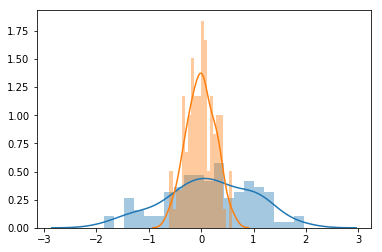

In [178]:
sns.distplot(out[:,0], bins = 20)
sns.distplot(test[1][:,0], bins = 20)

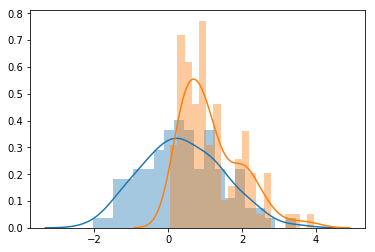

In [179]:
sns.distplot(out[:,2], bins = 20)
sns.distplot(test[1][:,2], bins = 20)

In [13]:
tfd = tfp.distributions

In [17]:
#### Create encooder
def build_encoder(latent_dim, hidden_dim, filters, kernels,nb_of_bands, conv_activation=None, dense_activation=None):#'sofplus'
    """
    Return encoder as model
    latent_dim : dimension of the latent variable
    hidden_dim : dimension of the dense hidden layer
    filters: list of the sizes of the filters used for this model
    list of the size of the kernels used for each filter of this model
    conv_activation: type of activation layer used after the convolutional layers
    dense_activation: type of activation layer used after the dense layers
    nb_of bands : nb of band-pass filters needed in the model
    """
    # input_layer = Input(shape=(64,64,nb_of_bands))

    # h = Reshape((64,64,nb_of_bands))(input_layer)
    # h = BatchNormalization()(h)
    # for i in range(len(filters)):
    #     h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
    #     h = PReLU()(h)
    #     h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
    #     h = PReLU()(h)
    # h = Flatten()(h)
    # h = Dense(hidden_dim, activation=dense_activation)(h)
    # h = PReLU()(h)
    # mu = Dense(latent_dim)(h)
    # sigma = Dense(latent_dim, activation='softplus')(h)

    tfd = tfp.distributions
    latent_dim = 32
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
                            reinterpreted_batch_ndims=1)

    encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(64,64,nb_of_bands)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[0], (kernels[0], kernels[0]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[1], (kernels[1], kernels[1]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[2], (kernels[2], kernels[2]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                    padding='same', activation=conv_activation),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Conv2D(filters[3], (kernels[3], kernels[3]),
                    padding='same', activation=conv_activation, strides=(2,2)),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim),
                activation=None),
        tf.keras.layers.Flatten(),
        tfp.layers.MultivariateNormalTriL(
            latent_dim,
            activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0)),
    ])


    return encoder


#### Create encooder
def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None):
    """
    Return decoder as model
    input_shape: shape of the input data
    latent_dim : dimension of the latent variable
    hidden_dim : dimension of the dense hidden layer
    filters: list of the sizes of the filters used for this model
    list of the size of the kernels used for each filter of this model
    conv_activation: type of activation layer used after the convolutional layers
    dense_activation: type of activation layer used after the dense layers
    """
    # input_layer = Input(shape=(latent_dim,))
    # h = Dense(hidden_dim, activation=dense_activation)(input_layer)
    # h = PReLU()(h)
    # h = Dense(hidden_dim*2, activation=dense_activation)(input_layer)
    # h = PReLU()(h)
    # h = tfp.distributions.MultivariateNormalDiag()
    final_dim = 3

    prior_output = tfd.Independent(tfd.Normal(loc=tf.zeros(final_dim), scale=1),
                            reinterpreted_batch_ndims=1)

    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim)),
        tf.keras.layers.Dense(512, activation=None),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(256, activation=None),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(final_dim),
                activation=None),
        tfp.layers.MultivariateNormalTriL(final_dim)
    ])

    return decoder



# Function to define model

def vae_model(latent_dim, nb_of_bands):
    """
    Function to create VAE model
    nb_of bands : nb of band-pass filters needed in the model
    """

    #### Parameters to fix
    # batch_size : size of the batch given to the network
    # input_shape: shape of the input data
    # latent_dim : dimension of the latent variable
    # hidden_dim : dimension of the dense hidden layer
    # filters: list of the sizes of the filters used for this model
    # kernels: list of the size of the kernels used for each filter of this model

    batch_size = 100 
    
    input_shape = (64, 64, nb_of_bands)
    hidden_dim = 256
    filters = [32, 64, 128, 256]
    kernels = [3,3,3,3]

    # Build the encoder
    encoder = build_encoder(latent_dim, hidden_dim, filters, kernels, nb_of_bands)
    # Build the decoder
    decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)

    
    return encoder, decoder

In [18]:
encoder, decoder = vae_model(32, 6)

model = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu_17 (PReLU)           (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_18 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        1849

In [20]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [21]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss=negative_log_likelihood, metrics=['mse'])

In [ ]:
######## Train the network
hist = model.fit_generator(generator=training_generator, epochs=20,
          steps_per_epoch=8,#128
          verbose=1,
          shuffle=True,
          validation_data=validation_generator,
          validation_steps=2,#16
          #callbacks=callbacks,
          #max_queue_size=4,
          workers=0,#4 
          use_multiprocessing = False)

Epoch 1/20
8/8 [==============================] - 23s 3s/step - loss: 10.7011 - mse: 1.3789 - val_loss: 11.1944 - val_mse: 1.5431
Epoch 2/20
8/8 [==============================] - 19s 2s/step - loss: 9.3604 - mse: 1.3013 - val_loss: 8.0239 - val_mse: 1.2410
Epoch 3/20
8/8 [==============================] - 17s 2s/step - loss: 7.5626 - mse: 1.1679 - val_loss: 6.1336 - val_mse: 1.0976
Epoch 4/20
8/8 [==============================] - 16s 2s/step - loss: 4.8748 - mse: 1.0229 - val_loss: 4.9552 - val_mse: 1.0524
Epoch 5/20
8/8 [==============================] - 15s 2s/step - loss: 4.0436 - mse: 0.9659 - val_loss: 3.1638 - val_mse: 0.9072
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 3.3799 - mse: 0.8712 - val_loss: 2.8609 - val_mse: 0.9065
Epoch 7/20
8/8 [==============================] - 14s 2s/step - loss: 2.9533 - mse: 0.8134 - val_loss: 2.6387 - val_mse: 0.7661
Epoch 8/20
8/8 [==============================] - 13s 2s/step - loss: 2.6600 - mse: 0.7652 - val_loss:

In [279]:
test = training_generator.__getitem__(2)

In [280]:
out = model.predict(test[0])

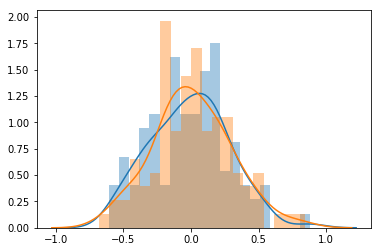

In [281]:
sns.distplot(out[:,0], bins = 20)
sns.distplot(test[1][:,0], bins = 20)

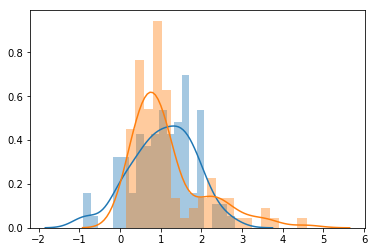

In [282]:
sns.distplot(out[:,2], bins = 20)
sns.distplot(test[1][:,2], bins = 20)

In [283]:
print(out[:,2])

[ 1.7217293   0.8821109  -0.07805949 -0.9111776   2.0128024   0.6241628
  2.0201128   0.86363286  0.05856061  1.6288843   2.8217096   1.239708
  1.6447608   1.6213908   1.0330833   0.10366505  0.47666746  0.6071119
  0.6937348   0.12835085  2.0007744   0.9191674   1.6952224   1.6668725
  1.475757    2.3583367   2.0119946   0.94068897  1.1634471   1.6641474
  1.1032076  -0.03303921  1.6483481  -0.15157431  0.57106936  1.430053
  2.6346593   0.18079817  0.68502504  2.3311448   1.3789172   1.511142
 -0.13274527  1.2875834   0.463654    0.53283834  1.1207008   0.6515695
  1.7630503   1.0027022   0.60666513 -0.03694928  1.5720983   0.37975663
  1.3906693   1.5281181   0.48871678  0.964806    1.1679019   1.2853928
  1.414041    1.9823854  -0.6705128   0.15784776  1.3769997   1.2592883
  0.30435264  0.9929921   0.81915665  1.0822244   0.5606001   1.6867698
  0.03388     1.4905257  -0.01263738  0.34085166  0.9334474   2.04547
  1.6071746   1.9261372   0.71732014  0.7982101   1.3039705   0.4442

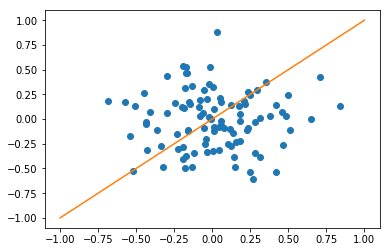

In [284]:
plt.plot(test[1][:,0], out[:,0], 'o')
x = np.linspace(-1,1)
plt.plot(x, x)

In [291]:
test_2 = np.load(list_of_samples[0], mmap_mode = 'c')[:10000,1,4:]

In [292]:
test_2 = test_2.transpose(0,2,3,1)

In [293]:
test_2.shape

(10000, 64, 64, 6)

In [294]:
out = model.predict(test_2)

In [295]:
data = pd.read_csv('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/test/galaxies_isolated_20191024_0_data.csv')

input_test = data['e1'][:10000]

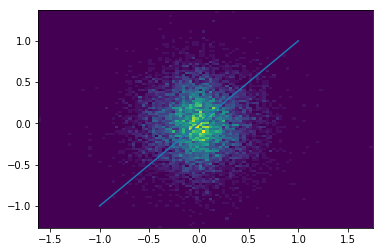

In [296]:
plt.hist2d(input_test, out[:,0], bins = 100)
x = np.linspace(-1,1)
plt.plot(x, x)